# Exploratory Data Analysis - Confidence Intervals and Hypothesis Testing

Welcome to the last notebook of the exploratory data analysis (EDA) series. For this notebook you will use the data on rideharing in the year 2022 in the city of Chicago, which can be found [here](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p/data). You have already worked with this dataset in the first and second notebooks of this series. This time you will continue working on the cleaned-up and reduced version of the dataset, which you prepared in week 1.

### Learning Objectives:
In this notebook you will use the following concepts from the course in a practical setting:
 - Descriptive statistics (mean, standard deviation)
 - Confidence intervals
 - Two sample t-test
 - Linear regression

# 1. Import the Python Libraries

As usual, the first thing you need to do is import the libraries that you will use in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.formula.api as smf

# 2. Load the Dataset

The next step is to open the dataset. The dataset has been downsampled to work smoothly in this environment.

In [2]:
# Open the dataset
# Note the parse_dates parameter, which automatically saves the given columns as dates.
df = pd.read_csv("data/rideshare_2022_cleaned.csv", parse_dates=['trip_start_timestamp', 'date'])

# Show the first few lines of the dataset
df.head()

,trip_start_timestamp,trip_seconds,trip_miles,fare,tip,additional_charges,trip_total,shared_trip_authorized,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,date,weekday
0,2022-01-01,3905.0,44.5,55.0,0.0,11.25,66.25,0,1,41.972563,-87.678846,NaN,NaN,2022-01-01,Saturday
1,2022-01-01,2299.0,25.0,32.5,7.0,7.18,46.68,0,1,41.878866,-87.625192,NaN,NaN,2022-01-01,Saturday
2,2022-01-01,275.0,1.5,7.5,0.0,1.02,8.52,0,1,41.792357,-87.617931,41.812949,-87.617860,2022-01-01,Saturday
3,2022-01-01,243.0,1.0,5.0,0.0,2.36,7.36,0,1,41.936310,-87.651563,41.943155,-87.640698,2022-01-01,Saturday
4,2022-01-01,364.0,1.3,5.0,0.0,2.36,7.36,0,1,41.921855,-87.646211,41.936237,-87.656412,2022-01-01,Saturday


# 3. Investigate the Daily Number of Rides Through the Year

Have a look at the number of daily rides throughout the year. The goal here is to calculate the confidence interval for the (population) mean. This can help you predict the number of rides in the next year.

In [3]:
# Caclulate the daily number of rides through the whole year
daily_rides = df.groupby('date').size().reset_index(name='daily_rides')

# Show the dataframe
daily_rides

,date,daily_rides
0,2022-01-01,1557
1,2022-01-02,1102
2,2022-01-03,1207
3,2022-01-04,1151
4,2022-01-05,1235
...,...,...
360,2022-12-27,1557
361,2022-12-28,1663
362,2022-12-29,1797
363,2022-12-30,2177


Now that you have the number of rides for each day, you can calculate the sample mean and standard deviation. The terms mean and standard deviation have been used very loosely in the previous notebooks of the series, but you know better now. Since this is only a sample of the cab rides in Chicago, everything you get from this data will be an estimation of the true population. In other words, you're calculating sample means and sample variances, rather than population means.

In [4]:
# Calculate the mean and standard deviation of the number of rides
mean_rides_per_day = daily_rides['daily_rides'].mean()
std_rides_per_day = daily_rides['daily_rides'].std()

print(f'Mean number of rides per day: {mean_rides_per_day:.2f}')
print(f'Standard deviation: {std_rides_per_day:.2f}')

Mean number of rides per day: 1893.42
Standard deviation: 404.21


In the next cell you will plot the daily rides, and add a horizontal line representing the sample mean you got from the data

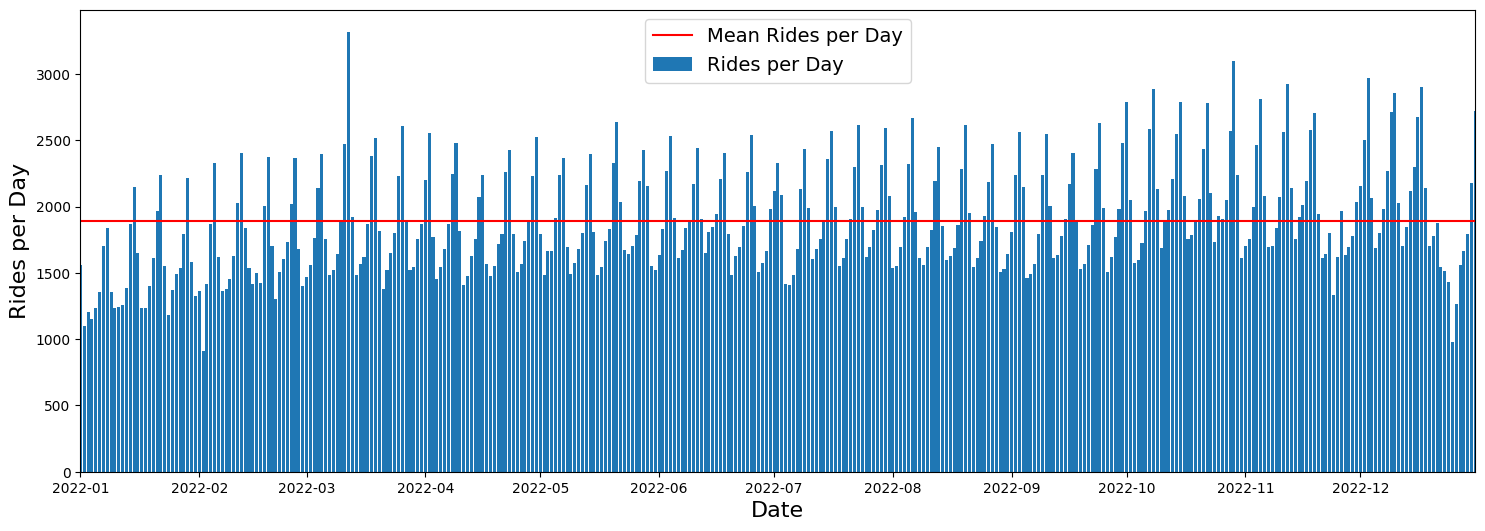

In [5]:
plt.figure(figsize=(18,6))
# Plot the histogram of the daily rides
plt.bar(daily_rides['date'], daily_rides['daily_rides'], label='Rides per Day')

# Plot the mean value as a horizontal line
plt.axhline(y=mean_rides_per_day, c='r', label=f'Mean Rides per Day')

plt.ylabel('Rides per Day', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.xlim(min(daily_rides['date']), max(daily_rides['date']))
plt.legend(fontsize=14)
plt.show()

Above you have calculated the mean number of rides per day. But how confident can you be in this mean?

## 3.1 Confidence Intervals
As you learned in this week, one way of anwering the previous question is by using confidence intervals.  Go ahead and find the 95% confidence interval for the mean number of daily rides. Since you don't know the standard deviation (you actually know nothing of the distribution), you need to construct the confidence interval using the $t$ distribution.
<img src="./images/t-CI-screenshot.png" width=150)>

In [6]:
# Define the confidence interval you are interested in
confidence = 0.95

# Calculate the critical value using scipy
critical_value = scipy.stats.t.ppf(1 - (1 - confidence)/2, df=len(daily_rides)-1)

print(f"For the confidence interval of {confidence}, the critical value is {critical_value}")

# Calculate the confidence interval
total_days = daily_rides['date'].count()
confidence_interval = critical_value * std_rides_per_day / np.sqrt(total_days)

print(f"With a {100 * confidence}% confidence you can say that your error will be no more than {confidence_interval:.4f} rides per day.")

For the confidence interval of 0.95, the critical value is 1.966502568799249
With a 95.0% confidence you can say that your error will be no more than 41.6059 rides per day.


Now that you have the mean number of rides and the confidence interval, it would be good to plot them together, to see how they look.

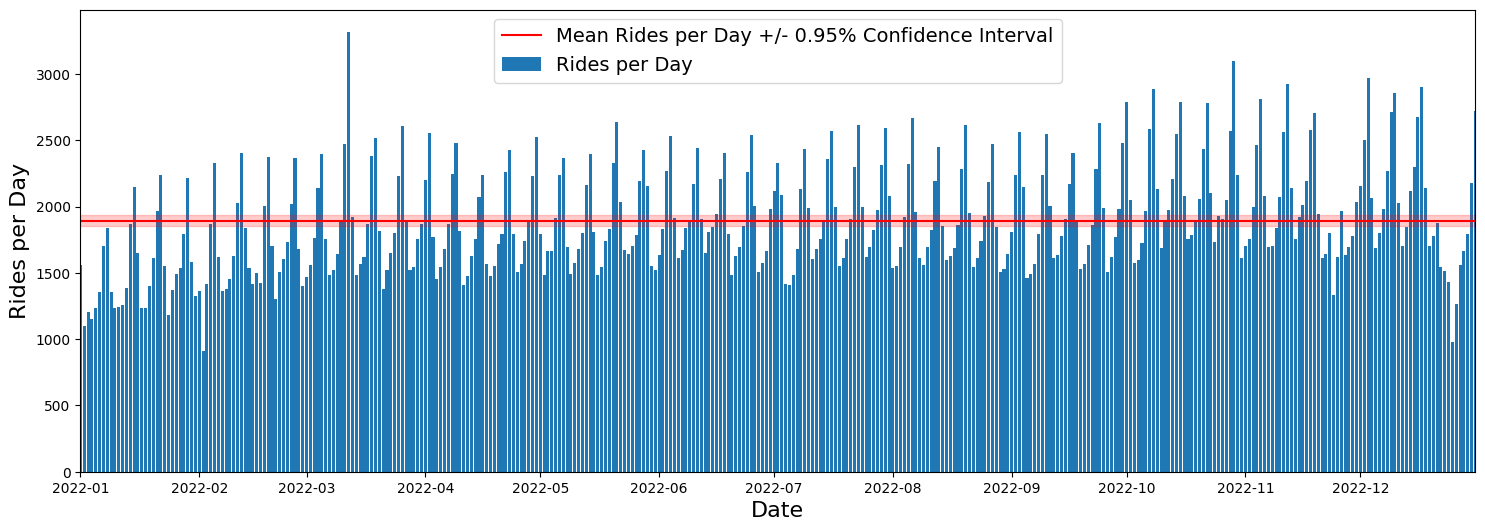

In [7]:
plt.figure(figsize=(18,6))
# Plot the histogram of the daily rides
plt.bar(daily_rides['date'], daily_rides['daily_rides'], label='Rides per Day')

# Plot the mean value as a horizontal line
plt.axhline(y=mean_rides_per_day, c='r', label=f'Mean Rides per Day +/- {confidence}% Confidence Interval')
# Plot the confidence interval around the line
plt.fill_between(daily_rides['date'], mean_rides_per_day-confidence_interval,
                 mean_rides_per_day+confidence_interval, color='r', alpha=0.2)

plt.ylabel('Rides per Day', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.xlim(min(daily_rides['date']), max(daily_rides['date']))
plt.legend(fontsize=14)
plt.show()

You can see that your confidence interval is very narrow, which implies that you can be very confident in your estimation of the mean. At least with 95% confidence, the population mean will not be too far from the sample mean. This observation may seem counterintuitive at first, as you can see that the data varies a lot more. But remember, the confidence interval does not describe the data, but the mean of the population. Since you have so many datapoints (one for each day), your estimate of the mean is very precise, even though the standard deviation is relatively large (about 10x larger than your confidence interval for the mean).

Notice an interesting thing: in the last two weeks of the year (holiday season) the number of rides seems to drop quite significantly. Perhaps you could isolate this part of the data and separately estimate a confidence interval for the population mean for only those weeks.

In [8]:
# Select the data only for holidays
daily_rides_holidays = daily_rides[daily_rides["date"] > "2022-12-17"]

# Compute sample mean and standard deviation for holidays
mean_rides_per_day_holidays = daily_rides_holidays['daily_rides'].mean()
std_rides_per_day_holidays = daily_rides_holidays['daily_rides'].std()

print(f'Mean number of rides per day: {mean_rides_per_day_holidays:.2f} +/- {std_rides_per_day_holidays:.2f}')

# Get the confidence interval for the population mean for the holidays.
critical_value_holidays =  scipy.stats.t.ppf(1 - (1 - confidence)/2, df=len(daily_rides_holidays)-1)
total_days_holidays = daily_rides_holidays['date'].count()
confidence_interval_holidays = critical_value_holidays * std_rides_per_day_holidays / np.sqrt(total_days_holidays)
print(f"With a {100 * confidence}% confidence you can say that your error will be no more than {confidence_interval_holidays} rides per day.")

Mean number of rides per day: 1725.21 +/- 426.10
With a 95.0% confidence you can say that your error will be no more than 246.02055491847958 rides per day.


What you may notice here is that while the mean is lower and you have a similar standard deviation, the confidence interval for the mean is much larger. This is because you used only 14 datapoints (two weeks of data) rather than the whole year.

In the cell below, you can plot the same plot again, but with the data for the holidays superimposed for comparison.

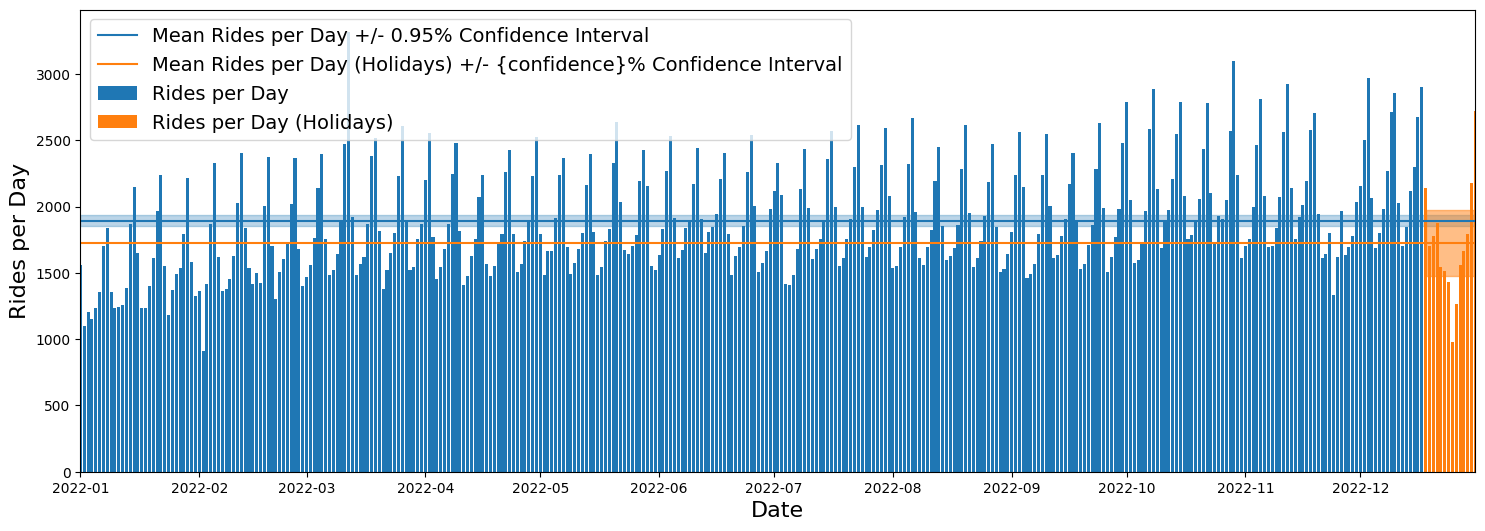

In [9]:
plt.figure(figsize=(18,6))

# Plot the histogram of the daily rides, the mean and the confidence interval
plt.bar(daily_rides['date'], daily_rides['daily_rides'], label='Rides per Day')
plt.axhline(y=mean_rides_per_day, color='C0', label=f'Mean Rides per Day +/- {confidence}% Confidence Interval')
plt.fill_between(daily_rides['date'], mean_rides_per_day-confidence_interval,
                 mean_rides_per_day+confidence_interval, color='C0', alpha=0.3)

# Plot the histogram of the daily rides, the mean and the confidence interval for the holiday season
plt.bar(daily_rides_holidays['date'], daily_rides_holidays['daily_rides'], label='Rides per Day (Holidays)')
plt.axhline(y=mean_rides_per_day_holidays, color='C1', label='Mean Rides per Day (Holidays) +/- {confidence}% Confidence Interval')

plt.fill_between(daily_rides_holidays['date'], mean_rides_per_day_holidays-confidence_interval_holidays,
                 mean_rides_per_day_holidays+confidence_interval_holidays, color='C1', alpha=0.5)

plt.ylabel('Rides per Day', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.xlim(min(daily_rides['date']), max(daily_rides_holidays['date']))
plt.legend(fontsize=14)
plt.show()

This is where confidence intervals come in realy handy as you can talk about the confidence of your estimates. Looking at the plot above you can see that the blue line (mean for the entire year) falls within the orange shaded area (95% confidence interval for the mean of the rides during holidays). Collecting data for more years would give you more datapoints and thus a narrower confidente interval for the same confidenve level. This means you are more certain about you sample mean estimation.

## 3.2 Two Sample t-test

Another thing you probably noticed in the plot are the periodic peaks. If you look closely, they appear with a period of 7 days, which gives you a hint that there are more rides on some days of the week than others. Run the cell below to group the weekdays together and calculate the mean and standard deviation for the number of rides each day.

In [10]:
WEEKDAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_rides['weekday'] = daily_rides['date'].apply(lambda x: WEEKDAYS[x.weekday()])

weekday_summary = daily_rides.groupby('weekday')['daily_rides'].describe()
# Reorder the series given weekdays
weekday_summary = weekday_summary.reindex(WEEKDAYS)
weekday_summary

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
Monday,52.0,1519.480769,145.334839,1182.0,1459.25,1526.5,1610.25,1759.0
Tuesday,52.0,1588.000000,163.861371,1151.0,1523.75,1571.5,1671.75,1931.0
Wednesday,52.0,1692.961538,205.725971,908.0,1631.00,1702.5,1783.00,2121.0
Thursday,52.0,1840.788462,218.758739,1332.0,1777.25,1865.0,1947.00,2303.0
Friday,52.0,2229.288462,253.053458,1518.0,2136.00,2238.5,2364.50,2712.0
Saturday,53.0,2507.018868,331.347685,1435.0,2394.00,2528.0,2671.00,3320.0
Sunday,52.0,1864.596154,251.750675,977.0,1765.25,1910.5,2039.75,2238.0


You can clearly see that there are a larger number of rides on Fridays and Saturdays than on the rest of the week (perhaps due to people going out on the weekend?). But can you be sure you have enough evidence to claim this? Let's find that out with a hypothesis test!

In this case, you can test your assumption with a two sample t-test. Remember that for this test, you used the following test statistic

<img src="./images/2sample-t-test-screenshot.png" width=500)>

This can be done very easily using the `scipy` library. You just need to call the function `scipy.stats.ttest_ind()` and pass it the two samples. If you call $\mu_{FS}$ the population mean for the number of rides on Fridays and Saturdays, and $\mu_{other}$ the population mean for the rest of the weekdays, in this case you can propose the the following hypotheses:

 - Null hypothesis ($H_0$): $\mu_{FS} \leq \mu_{other}$ (population mean of the first group is smaller or equal than that for the the other group)
 - Alternative hypothesis ($H_1$): $\mu_{FS} > \mu_{other}$ (population mean of the first group is bigger than that for the the other group)

Since you want to prove that the the population mean on Fridays and Saturdays is bigger, that's what you set as the alternative hypothesis.

The function returns the value of the statistic and the p-value. You can now compare the p-value with your desired significance level, for example $\alpha=0.05$, to determine whether you can reject the null hypothesis.

In [11]:
# Create two series, one for the numbers of rides on every friday and saturday and one for the other days
fridays_and_saturdays = daily_rides[daily_rides["weekday"].isin(["Friday", "Saturday"])]["daily_rides"]
other_days = daily_rides[daily_rides["weekday"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Sunday"])]["daily_rides"]

# Note that these series contain all days, not the summary from the dataframe in the previous cell
print(f"Number of datapoints for Fridays and Saturdays: {len(fridays_and_saturdays)}")
print(f"Number of datapoints for other days: {len(other_days)}")

# Calculate the t
scipy.stats.ttest_ind(a=fridays_and_saturdays, b=other_days, alternative='greater')

Number of datapoints for Fridays and Saturdays: 105
Number of datapoints for other days: 260


TtestResult(statistic=np.float64(21.56892206841357), pvalue=np.float64(2.659107372508349e-67), df=np.float64(363.0))

In [12]:
fridays_and_saturdays

0      1557
6      1705
7      1836
13     1871
14     2150
       ... 
350    2906
356    1518
357    1435
363    2177
364    2720
Name: daily_rides, Length: 105, dtype: int64

Here the output gives you an extremely small p-value, which means you would reject the null hypothesis and say that people actually take more rides on Fridays and Saturdays, even with very tiny significance levels.

# 4. Calculating the Fares Given Trip Distance and Time

In this section you will try to try to calculate how much the drivers can charge for the rides given your data. Usually rideshare comapanies charge a certain amount per unit time and a certain amount for the distance covered. You can assume that this is also the case here. First you can plot some scatter plots to see how the variables correlate with each other.


<Axes: xlabel='fare', ylabel='trip_miles'>

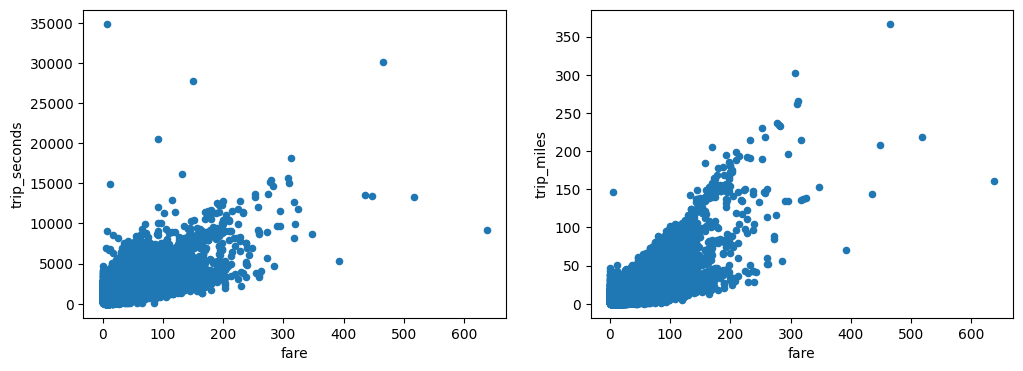

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df.plot.scatter('fare','trip_seconds', ax=ax[0])
df.plot.scatter('fare','trip_miles', ax=ax[1])

As you can see, these variables seem highly correlated and are good candidates for a linear regression. In the previous week "World Happiness" lab, you used `scikit-learn` to perform linear regression. This is a machine learning oriented library. This week you will use another library called `statsmodels`. You can find the documentation [here](https://www.statsmodels.org/stable/index.html). This library is much more statistics oriented, but using it is just as easy. With just a few lines of code, you can fit the model and display a nice and detailed summary.

In the cell below you will fit a model, using `trip_seconds` and `trip_miles` as explanatory variables and `fare` as the response.

In [14]:
# Create the model
model = smf.ols(formula='fare ~ trip_seconds + trip_miles', data=df)

# Fit the model
result = model.fit()

# Display the results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 4.655e+05
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        15:01:49   Log-Likelihood:            -2.5085e+06
No. Observations:              689925   AIC:                         5.017e+06
Df Residuals:                  689922   BIC:                         5.017e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.4621      0.020    329.648   

One interesting thing about using the StatsModels library it that it outputs a lot of information to help you decide if the model you proposed and trained is a good one. As you can see there are quite a lot of details about the model in this table.  While still very useful, some of them are outside the scope of this course. That said, you can still undersand a great deal of them! Don't be intimidated by all this information, here you will understand how to interpret most of it

The first part gives you information about the model:
```
Dep. Variable:                   fare  
Model:                            OLS  
Method:                 Least Squares  
Date:                Thu, 18 Jan 2024  
Time:                        20:45:54  
No. Observations:              689925  
Df Residuals:                  689922  
Df Model:                           2                                         
```
You can see that the dependent variable is the column `fare`, you see that it is using an OLS (Ordinary Least Squares) model to represent the linear regression. You can also check the date and time of when the model was trained. You can also check the number of obervations that were used to train the model. The residuals is nothing more than the sum of squared errors of the model, compared against the training data, and Df Model indicates how many explicative variables you used to train. You can forget about the column on the right for now. It gives you a lot of metrics to compare between different models, but it is way outside the scope of the course. 

Now, if you go to the middle section of the summary 
```
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.4621      0.020    329.648      0.000       6.424       6.501
trip_seconds     0.0056   2.51e-05    222.342      0.000       0.006       0.006
trip_miles       0.8693      0.003    343.709      0.000       0.864       0.874
```
it is giving you the value of the coefficients of the regression, but it gives you much more than that! Lets analyze column by column:
- `coef`: you get the estimated value for each of the coefficients. 
- `std_err`: shows you the standard error of the estimated value for each coefficient. 
The following columns all give you measures of how good the estimate is:
- `t`: computes the t statistic for the given coefficient. It is the same t statistic you used both in hypothesis testing and confidence intervals. Note that if the standard error is very smalled compared to the coeficient, this will make for a large statistic. 
- `P>|t|`: this column is very important. It represents the p-value for the t-statistic you got for null hypothesis that the coefficient is actually 0. In other words, it shows how likely your coefficient is measured through your model by chance. In this example, all this probabilities are 0, so it means all the considered variables (and the intercept) play an important role on the regression model
- `[0.025    0.975]`: these two columns give you the lower and upper limmits for a 95% confidence interval for each coefficient. In this example, since you've got a lot of observations and proposed a good model, this intervals are very narrow. 

Now let's see what information you can get about the remaining values. `Skew` and `kurtosis` give you the skewness and kurtosis of the residues. Remember that the residue is the squared difference between your observation and the predicted output of the model. It is a good way to know how the errors of the model are distributed. 

This is the last of the values you can actually completely understand from what you've seen on this course. However, there are more that you can at least intuitively understand. Both  (`Omnibus` and `Prob(Omnibus)`) and (`Jarque-Bera (JB)` and `Prob(JB)`) represent hypothesis tests. They are both very particular tests, where the alternative hypothesis is that the residues are not normally distributed. Of course, they are not like any of the tests you've leaned so far, because it doesn't use the same statistics, but the way in which you interpret the test is still the same. The values of `Omnibus` and `Jarque-Bera (JB)` are the values of the statistic of each test, while `Prob(Omnibus)` and `Prob(JB` are the p-values. Note that in both of this tests, a small p-value indicates that the residues are not normally distributed.

The rest of the values on the summary table are completely outside the scope of the course, but you have plenty of information you can work with!

From the `result`object you can access a lot of the information. For example, run the cell below to access the parameters of the fit.

In [15]:
result.params

Intercept       6.462145
trip_seconds    0.005589
trip_miles      0.869281
dtype: float64

You can also access each individual parameter as shown in the cell below.

In [16]:
starting_fare = result.params["Intercept"]
price_per_second = result.params["trip_seconds"]
price_per_mile = result.params["trip_miles"]

print(f"The starting fare is {starting_fare:.3} USD. In addition the ride costs {price_per_second*60:.3} USD per minute and {price_per_mile:.3} USD per mile.")

The starting fare is 6.46 USD. In addition the ride costs 0.335 USD per minute and 0.869 USD per mile.


Now that you have the coefficients for your model, you can define a simple fare calculator that can predicts the price of the trip for you based on the distiance and the duration.

In [17]:
def fare_calculator(trip_time, trip_distance):
    return starting_fare + price_per_second * trip_time + price_per_mile * trip_distance

sample_trip_duration = 10 * 60 # 10 minutes
sample_trip_distance = 10 # 10 miles

sample_fare = fare_calculator(sample_trip_duration, sample_trip_distance)

print(f"For a {sample_trip_distance} mile trip that takes {sample_trip_duration/60} minutes, you would pay around {sample_fare:.3} USD.")

For a 10 mile trip that takes 10.0 minutes, you would pay around 18.5 USD.


Lastly, plot the data and the predictions together to see how well the model performs.

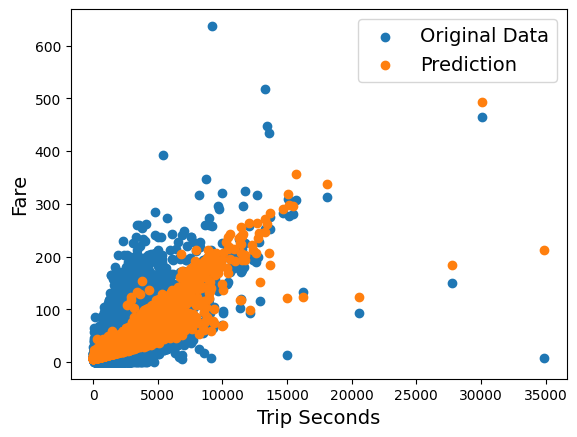

In [18]:
# Get the x and y data that you used to fit the model and drop nan values
x_y = df[["trip_miles", "trip_seconds", "fare"]].dropna()

# Change this row if you want to choose another x variable (trip_miles or trip_seconds) to plot
x_variable = "trip_seconds"

# Get the plotting data
x_plot =  x_y[x_variable]
y_plot =  x_y["fare"]
y_result = result.predict()

# Plot the data
plt.scatter(x_plot, y_plot, label="Original Data")
plt.scatter(x_plot, y_result, label="Prediction")
plt.xlabel(" ".join(x_variable.split("_")).title(), fontsize=14)
plt.ylabel("Fare", fontsize=14)
plt.legend(fontsize=14)

Of course there is some variance in the data that is not explained by the model, but it didn't do that bad for a model that only uses 2 variables!

**Congratulations on finishing this lab.** You have used the implementation of quite a few concepts covered in this course: descriptive statistics (mean, standard deviation), confidence intervals, two sample t-test and linear regression. On top of that you have practiced Pandas and plotting. We hope you have enjoyed this series of notebooks!